# Ethereum Blockchain Explorer
Some functions to help explore the ethereum blockchain using JSON RPC on the BlockScience geth node

In [345]:
import requests, json
import pandas as pd
import numpy as np
SESSION = requests.Session()
f = open("node_ip.txt","r")
RPC_HOST = f.readline()
RPC_HOST = str.replace(RPC_HOST,'\n','')
RPC_PORT = '8545'
RPC_URL = 'http://'+RPC_HOST+':'+RPC_PORT

## Basic JSON downloading

In [249]:
def getJSON(url, d=None):
    h = {"Content-Type": "application/json"}
    if d is None:
        r = SESSION.get(url, headers=h)
    else:
        r = SESSION.post(url, data=d, headers=h)
    json_data = r.text
    response = json.loads(json_data)
    return response

In [250]:
def getRawJSON(url, d=None):
    h = {"Content-Type": "application/json"}
    if d is None:
        r = SESSION.get(url, headers=h)
    else:
        r = SESSION.post(url, data=d, headers=h)
    json_data = r.text
    return json_data

In [251]:
# test if the getJSON function supports GET requests
# getJSON('https://api.etherscan.io/api?module=account&action=balance&address=0xde0b295669a9fd93d5f28d9ec85e40f4cb697bae&tag=latest&apikey=YourApiKeyToken')

In [252]:
# test if the getJSON function supports POST requests
# getJSON(RPC_URL,'{"jsonrpc":"2.0","method":"eth_syncing","params":[],"id":1}')

## Consensys EthJsonRpc Package

I wasn't able to quickly make the package work on Python 3

In [253]:
# from ethjsonrpc import EthJsonRpc
# c = EthJsonRpc('35.196.250.157', 8545)
# print(c.net_version())
# print(c.web3_clientVersion())
# print(c.eth_gasPrice())

So I began copying their functions. Most of them still need testing. Ideally we should fork and make our own package compatible with Python 3

In [254]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def hex_to_dec(x):
    '''
    Convert hex to decimal
    '''
    return int(x, 16)

In [255]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def clean_hex(d):
    '''
    Convert decimal to hex and remove the "L" suffix that is appended to large
    numbers
    '''
    return hex(d).rstrip('L')

In [256]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def validate_block(block):
#     doesn't work on Python 3
#     if isinstance(block, basestring):
#         if block not in BLOCK_TAGS:
#             raise ValueError('invalid block tag')
    if isinstance(block, int):
        block = hex(block)
    return block

In [257]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def wei_to_ether(wei):
    '''
    Convert wei to ether
    '''
    return 1.0 * wei / 10**18

In [258]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def ether_to_wei(ether):
    '''
    Convert ether to wei
    '''
    return ether * 10**18

In [259]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/exceptions.py
class EthJsonRpcError(Exception):
    pass
class ConnectionError(EthJsonRpcError):
    pass
class BadStatusCodeError(EthJsonRpcError):
    pass
class BadJsonError(EthJsonRpcError):
    pass
class BadResponseError(EthJsonRpcError):
    pass

In [260]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
BLOCK_TAG_EARLIEST = 'earliest'
BLOCK_TAG_LATEST   = 'latest'
BLOCK_TAG_PENDING  = 'pending'
BLOCK_TAGS = (
    BLOCK_TAG_EARLIEST,
    BLOCK_TAG_LATEST,
    BLOCK_TAG_PENDING,
)

In [261]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def _call(method, params=None, _id=1):
    params = params or []
    data = {
        'jsonrpc': '2.0',
        'method':  method,
        'params':  params,
        'id':      _id,
    }
    scheme = 'http'
#     if tls:
#         scheme += 's'
    url = '{}://{}:{}'.format(scheme, RPC_HOST, RPC_PORT)
    headers = {'Content-Type': 'application/json'}
    try:
        r = SESSION.post(url, headers=headers, data=json.dumps(data))
    except RequestsConnectionError:
        raise ConnectionError
    if r.status_code / 100 != 2:
        raise BadStatusCodeError(r.status_code)
    try:
        response = r.json()
    except ValueError:
        raise BadJsonError(r.text)
    try:
        return response['result']
    except KeyError:
        raise BadResponseError(response)

In [262]:
################################################################################
# high-level methods
################################################################################

In [263]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def transfer(from_, to, amount):
    '''
    Send wei from one address to another
    '''
    return eth_sendTransaction(from_address=from_, to_address=to, value=amount)

In [264]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def create_contract(from_, code, gas, sig=None, args=None):
    '''
    Create a contract on the blockchain from compiled EVM code. Returns the
    transaction hash.
    '''
    from_ = from_ or eth_coinbase()
    if sig is not None and args is not None:
         types = sig[sig.find('(') + 1: sig.find(')')].split(',')
         encoded_params = encode_abi(types, args)
         code += encoded_params.encode('hex')
    return eth_sendTransaction(from_address=from_, gas=gas, data=code)

In [265]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def get_contract_address(tx):
    '''
    Get the address for a contract from the transaction that created it
    '''
    receipt = eth_getTransactionReceipt(tx)
    return receipt['contractAddress']

In [266]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def call(address, sig, args, result_types):
    '''
    Call a contract function on the RPC server, without sending a
    transaction (useful for reading data)
    '''
    data = _encode_function(sig, args)
    data_hex = data.encode('hex')
    response = eth_call(to_address=address, data=data_hex)
    return decode_abi(result_types, response[2:].decode('hex'))

In [267]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def call_with_transaction(from_, address, sig, args, gas=None, gas_price=None, value=None):
    '''
    Call a contract function by sending a transaction (useful for storing
    data)
    '''
    gas = gas or DEFAULT_GAS_PER_TX
    gas_price = gas_price or DEFAULT_GAS_PRICE
    data = _encode_function(sig, args)
    data_hex = data.encode('hex')
    return eth_sendTransaction(from_address=from_, to_address=address, data=data_hex, gas=gas,
                                    gas_price=gas_price, value=value)

In [268]:
################################################################################
# JSON-RPC methods
################################################################################

In [269]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def web3_clientVersion():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#web3_clientversion
    NEEDS TESTING
    '''
    return _call('web3_clientVersion')

In [270]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def web3_sha3(data):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#web3_sha3
    NEEDS TESTING
    '''
    data = str(data).encode('hex')
    return _call('web3_sha3', [data])

In [271]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def net_version():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#net_version
    NEEDS TESTING
    '''
    return _call('net_version')

In [272]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def net_listening():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#net_listening
    NEEDS TESTING
    '''
    return _call('net_listening')

In [273]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def net_peerCount():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#net_peercount
    NEEDS TESTING
    '''
    return hex_to_dec(_call('net_peerCount'))

In [274]:
def eth_protocolVersion():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_protocolversion
    NEEDS TESTING
    '''
    return _call('eth_protocolVersion')

In [275]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_syncing():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_syncing
    TESTED - MARKUS 2018-02-07
    '''
    return _call('eth_syncing')

In [276]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_coinbase():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_coinbase
    NEEDS TESTING
    '''
    return _call('eth_coinbase')

In [277]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_mining():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_mining
    NEEDS TESTING
    '''
    return _call('eth_mining')

In [278]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_hashrate():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_hashrate
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_hashrate'))

In [279]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_gasPrice():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gasprice
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_gasPrice'))

In [280]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_accounts():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_accounts
    NEEDS TESTING
    '''
    return _call('eth_accounts')

In [281]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_blockNumber():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_blocknumber
    TESTED - MARKUS 2018-02-07
    '''
    return hex_to_dec(_call('eth_blockNumber'))

In [282]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBalance(address=None, block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getbalance
    TESTED - MARKUS 2018-02-07
    '''
    address = address or eth_coinbase()
    block = validate_block(block)
    return hex_to_dec(_call('eth_getBalance', [address, block]))

In [283]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getStorageAt(address=None, position=0, block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getstorageat
    NEEDS TESTING
    '''
    block = validate_block(block)
    return _call('eth_getStorageAt', [address, hex(position), block])

In [284]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionCount(address, block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactioncount
    TESTED - MARKUS 2018-02-07
    '''
    block = validate_block(block)
    return hex_to_dec(_call('eth_getTransactionCount', [address, block]))

In [285]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBlockTransactionCountByHash(block_hash):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getblocktransactioncountbyhash
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_getBlockTransactionCountByHash', [block_hash]))

In [286]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBlockTransactionCountByNumber(block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getblocktransactioncountbynumber
    NEEDS TESTING
    '''
    block = validate_block(block)
    return hex_to_dec(_call('eth_getBlockTransactionCountByNumber', [block]))

In [287]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getUncleCountByBlockHash(block_hash):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getunclecountbyblockhash
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_getUncleCountByBlockHash', [block_hash]))

In [288]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getUncleCountByBlockNumber(block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getunclecountbyblocknumber
    NEEDS TESTING
    '''
    block = validate_block(block)
    return hex_to_dec(_call('eth_getUncleCountByBlockNumber', [block]))

In [289]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getCode(address, default_block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getcode
    NEEDS TESTING
    '''
#     doesn't work on Python 3
#     if isinstance(default_block, basestring):
#         if default_block not in BLOCK_TAGS:
#             raise ValueError
    return _call('eth_getCode', [address, default_block])

In [290]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_sign(address, data):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_sign
    NEEDS TESTING
    '''
    return _call('eth_sign', [address, data])

In [291]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_sendTransaction(to_address=None, from_address=None, gas=None, gas_price=None, value=None, data=None,
                        nonce=None):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_sendtransaction
    NEEDS TESTING
    '''
    params = {}
    params['from'] = from_address or eth_coinbase()
    if to_address is not None:
        params['to'] = to_address
    if gas is not None:
        params['gas'] = hex(gas)
    if gas_price is not None:
        params['gasPrice'] = clean_hex(gas_price)
    if value is not None:
        params['value'] = clean_hex(value)
    if data is not None:
        params['data'] = data
    if nonce is not None:
        params['nonce'] = hex(nonce)
    return _call('eth_sendTransaction', [params])

In [292]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_sendRawTransaction(data):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_sendrawtransaction
    NEEDS TESTING
    '''
    return _call('eth_sendRawTransaction', [data])

In [293]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_call(to_address, from_address=None, gas=None, gas_price=None, value=None, data=None,
             default_block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_call
    NEEDS TESTING
    '''
#     doesn't work on Python 3
#     if isinstance(default_block, basestring):
#         if default_block not in BLOCK_TAGS:
#             raise ValueError
    obj = {}
    obj['to'] = to_address
    if from_address is not None:
        obj['from'] = from_address
    if gas is not None:
        obj['gas'] = hex(gas)
    if gas_price is not None:
        obj['gasPrice'] = clean_hex(gas_price)
    if value is not None:
        obj['value'] = value
    if data is not None:
        obj['data'] = data
    return _call('eth_call', [obj, default_block])

In [294]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_estimateGas(to_address=None, from_address=None, gas=None, gas_price=None, value=None, data=None,
                    default_block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_estimategas
    NEEDS TESTING
    '''
#     doesn't work on Python 3
#     if isinstance(default_block, basestring):
#         if default_block not in BLOCK_TAGS:
#             raise ValueError
    obj = {}
    if to_address is not None:
        obj['to'] = to_address
    if from_address is not None:
        obj['from'] = from_address
    if gas is not None:
        obj['gas'] = hex(gas)
    if gas_price is not None:
        obj['gasPrice'] = clean_hex(gas_price)
    if value is not None:
        obj['value'] = value
    if data is not None:
        obj['data'] = data
    return hex_to_dec(_call('eth_estimateGas', [obj, default_block]))

In [295]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBlockByHash(block_hash, tx_objects=True):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getblockbyhash
    NEEDS TESTING
    '''
    return _call('eth_getBlockByHash', [block_hash, tx_objects])

In [296]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBlockByNumber(block=BLOCK_TAG_LATEST, tx_objects=True):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getblockbynumber
    NEEDS TESTING
    '''
    block = validate_block(block)
    return _call('eth_getBlockByNumber', [block, tx_objects])

In [297]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionByHash(tx_hash):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactionbyhash
    NEEDS TESTING
    '''
    return _call('eth_getTransactionByHash', [tx_hash])

In [298]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionByBlockHashAndIndex(block_hash, index=0):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactionbyblockhashandindex
    NEEDS TESTING
    '''
    return _call('eth_getTransactionByBlockHashAndIndex', [block_hash, hex(index)])

In [299]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionByBlockNumberAndIndex(block=BLOCK_TAG_LATEST, index=0):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactionbyblocknumberandindex
    NEEDS TESTING
    '''
    block = validate_block(block)
    return _call('eth_getTransactionByBlockNumberAndIndex', [block, hex(index)])

In [300]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionReceipt(tx_hash):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactionreceipt
    NEEDS TESTING
    '''
    return _call('eth_getTransactionReceipt', [tx_hash])

In [301]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getUncleByBlockHashAndIndex(block_hash, index=0):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getunclebyblockhashandindex
    NEEDS TESTING
    '''
    return _call('eth_getUncleByBlockHashAndIndex', [block_hash, hex(index)])

In [302]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getUncleByBlockNumberAndIndex(block=BLOCK_TAG_LATEST, index=0):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getunclebyblocknumberandindex
    NEEDS TESTING
    '''
    block = validate_block(block)
    return _call('eth_getUncleByBlockNumberAndIndex', [block, hex(index)])

In [303]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getCompilers():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getcompilers
    NEEDS TESTING
    '''
    return _call('eth_getCompilers')

In [304]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_compileSolidity(code):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_compilesolidity
    NEEDS TESTING
    '''
    return _call('eth_compileSolidity', [code])

In [305]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_compileLLL(code):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_compilelll
    N/A
    '''
    return _call('eth_compileLLL', [code])

In [306]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_compileSerpent(code):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_compileserpent
    N/A
    '''
    return _call('eth_compileSerpent', [code])

In [307]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_newFilter(from_block=BLOCK_TAG_LATEST, to_block=BLOCK_TAG_LATEST, address=None, topics=None):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_newfilter
    NEEDS TESTING
    '''
    _filter = {
        'fromBlock': from_block,
        'toBlock':   to_block,
        'address':   address,
        'topics':    topics,
    }
    return _call('eth_newFilter', [_filter])

In [308]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_newBlockFilter():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_newblockfilter
    NEEDS TESTING
    '''
    return _call('eth_newBlockFilter')

In [309]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_newPendingTransactionFilter():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_newpendingtransactionfilter
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_newPendingTransactionFilter'))

In [310]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_uninstallFilter(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_uninstallfilter
    NEEDS TESTING
    '''
    return _call('eth_uninstallFilter', [filter_id])

In [311]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getFilterChanges(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getfilterchanges
    NEEDS TESTING
    '''
    return _call('eth_getFilterChanges', [filter_id])

In [312]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getFilterLogs(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getfilterlogs
    NEEDS TESTING
    '''
    return _call('eth_getFilterLogs', [filter_id])

In [313]:
#FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
#def eth_getLogs(filter_object):
#    return _call('eth_getLogs', [filter_object])

# redefined by Markus 2018-02-08
def eth_getLogs(from_block=BLOCK_TAG_LATEST, to_block=BLOCK_TAG_LATEST, address=None, topics=None):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getlogs
    TESTED - MARKUS 2018-02-08
    '''
    _filter = {
        'fromBlock': from_block,
        'toBlock':   to_block,
        'address':   address,
        'topics':    topics,
    }
    return _call('eth_getLogs', [_filter])

In [314]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getWork():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getwork
    NEEDS TESTING
    '''
    return _call('eth_getWork')

In [315]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_submitWork(nonce, header, mix_digest):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_submitwork
    NEEDS TESTING
    '''
    return _call('eth_submitWork', [nonce, header, mix_digest])

In [316]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_submitHashrate(hash_rate, client_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_submithashrate
    NEEDS TESTING
    '''
    return _call('eth_submitHashrate', [hex(hash_rate), client_id])

In [317]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_version():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_version
    N/A
    '''
    return _call('shh_version')

In [318]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_post(topics, payload, priority, ttl, from_=None, to=None):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_post
    NEEDS TESTING
    '''
    whisper_object = {
        'from':     from_,
        'to':       to,
        'topics':   topics,
        'payload':  payload,
        'priority': hex(priority),
        'ttl':      hex(ttl),
    }
    return _call('shh_post', [whisper_object])

In [319]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_newIdentity():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_newidentity
    N/A
    '''
    return _call('shh_newIdentity')

In [320]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_hasIdentity(address):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_hasidentity
    NEEDS TESTING
    '''
    return _call('shh_hasIdentity', [address])

In [321]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_newGroup():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_newgroup
    N/A
    '''
    return _call('shh_newGroup')

In [322]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_addToGroup():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_addtogroup
    NEEDS TESTING
    '''
    return _call('shh_addToGroup')

In [323]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_newFilter(to, topics):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_newfilter
    NEEDS TESTING
    '''
    _filter = {
        'to':     to,
        'topics': topics,
    }
    return _call('shh_newFilter', [_filter])

In [324]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_uninstallFilter(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_uninstallfilter
    NEEDS TESTING
    '''
    return _call('shh_uninstallFilter', [filter_id])

In [325]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_getFilterChanges(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_getfilterchanges
    NEEDS TESTING
    '''
    return _call('shh_getFilterChanges', [filter_id])

In [326]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_getMessages(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_getmessages
    NEEDS TESTING
    '''
    return _call('shh_getMessages', [filter_id])    

In [327]:
eth_syncing()

False

In [328]:
eth_blockNumber()

5054920

In [329]:
eth_getBalance(address='0x267be1C1D684F78cb4F6a176C4911b741E4Ffdc0')

130690668423755103961362

In [330]:
eth_getTransactionCount('0x267be1C1D684F78cb4F6a176C4911b741E4Ffdc0')

762653

In [ ]:
MEW_TOKENS = getJSON('https://raw.githubusercontent.com/MyEtherWallet/ethereum-lists/master/tokens/tokens-eth.json')
MEW_TOKENS = pd.DataFrame.from_dict(MEW_TOKENS)
MEW_TOKENS.head()

In [372]:
tokens_of_interest = {
    'DAI': '',
    'MKR': ''
}
for token in tokens_of_interest:
    tokens_of_interest[token] = MEW_TOKENS[MEW_TOKENS['symbol']==token]['address'].to_string(index=False)
tokens_of_interest

{'DAI': '0x89d24A6b4CcB1B6fAA2625fE562bDD9a23260359',
 'MKR': '0x9f8F72aA9304c8B593d555F12eF6589cC3A579A2'}

In [392]:
def getTokenTransfers(address, from_block, to_block):
    ERC20_transfer_signature = '0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef'
    json = eth_getLogs(from_block=from_block, 
                       to_block=to_block,
                       address=address,
                       topics=[ERC20_transfer_signature])
    df = pd.DataFrame.from_dict(json)
    #TODO: get decimals from MEW
    df['amount'] = recent_DAI_transfers['data'].apply(lambda x: float.fromhex(x)*1e-18)
    df['from'] = recent_DAI_transfers['topics'].apply(lambda x: x[1][:2]+x[1][-40:])
    df['to'] = recent_DAI_transfers['topics'].apply(lambda x: x[2][:2]+x[2][-40:])
    return df

from_block = hex(eth_blockNumber() - 10000)
to_block = hex(eth_blockNumber())
txns = None
for token in tokens_of_interest:
    tmp = getTokenTransfers(tokens_of_interest[token],
                            from_block,
                            to_block)
    if tmp is None:
        continue
    tmp['token'] = token
    tmp['token_address'] = tokens_of_interest[token]
    if txns is None:
        txns = tmp
    else:
        txns = txns.append(tmp, ignore_index=True)

In [393]:
txns.head()

,address,blockHash,blockNumber,data,logIndex,removed,topics,transactionHash,transactionIndex,amount,from,to,token,token_address
0,0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359,0x0a40dadcac5d78ba83a22c583a2ece43c2692a543abd...,0x4cff8e,0x00000000000000000000000000000000000000000000...,0x30,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0x6cf89c28bd9b3b329f876301fa1cf36abfd5dfbba3b1...,0x5f,3625.0,0x14fbca95be7e99c15cc2996c6c9d841e54b79425,0x746e17548b63b0689e054d84a09abe1f5b70672c,DAI,0x89d24A6b4CcB1B6fAA2625fE562bDD9a23260359
1,0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359,0x1339d414bf6ce64f950129b1a7498df680784747fc52...,0x4cff94,0x00000000000000000000000000000000000000000000...,0xb,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0x4305f166fe8adfd5e8dba816125c01571ac59e79eacf...,0x77,3625.0,0x746e17548b63b0689e054d84a09abe1f5b70672c,0xb950f5c190472049762e0a250e10d94b81e15ddd,DAI,0x89d24A6b4CcB1B6fAA2625fE562bDD9a23260359
2,0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359,0x6be818f4cf7265bed33970456cea54547cb5ef14c551...,0x4cffb7,0x00000000000000000000000000000000000000000000...,0x25,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0x794c1d578bfa0381dee9fb3da23860f5691f6cf61a0d...,0x72,24000.0,0x14fbca95be7e99c15cc2996c6c9d841e54b79425,0x004075e4d4b1ce6c48c81cc940e2bad24b489e64,DAI,0x89d24A6b4CcB1B6fAA2625fE562bDD9a23260359
3,0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359,0x06d6c83500d7e0f14d08b9e2bdb4a8be6ffe6f9e9d9f...,0x4cffb9,0x00000000000000000000000000000000000000000000...,0x92,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0xaa75b2605e6cea3649ba1af7e47a48bf5e2357909b3c...,0x62,40000.0,0x14fbca95be7e99c15cc2996c6c9d841e54b79425,0x0005abcbb9533cf6f9370505ffef25393e0d2852,DAI,0x89d24A6b4CcB1B6fAA2625fE562bDD9a23260359
4,0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359,0xa89e220ca09395684a681372ec9abff6d06f02e03044...,0x4cffe9,0x00000000000000000000000000000000000000000000...,0x23,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0xb8fdac8d8f1e1db5b45300ec55bde6521540ecfecf88...,0x93,40000.0,0x0005abcbb9533cf6f9370505ffef25393e0d2852,0x14fbca95be7e99c15cc2996c6c9d841e54b79425,DAI,0x89d24A6b4CcB1B6fAA2625fE562bDD9a23260359


In [394]:
txns.tail()

,address,blockHash,blockNumber,data,logIndex,removed,topics,transactionHash,transactionIndex,amount,from,to,token,token_address
1315,0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2,0xcca2068a2b339225936d6b7fecff501d4b5b2380b9bd...,0x4d263c,0x00000000000000000000000000000000000000000000...,0x5d,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0x8e5321ca2e4a1973918b47ce8660ae54fdf160a96731...,0x9b,4000.000000,0xf87a7ec94884f44d9de33d36b73f42c7c0dd38b1,0x578f3c8454f316293dbd31d8c7806050f3b3e2d8,MKR,0x9f8F72aA9304c8B593d555F12eF6589cC3A579A2
1316,0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2,0x1930f515faef5aa5968917e823e3360a2227632f76b7...,0x4d263d,0x00000000000000000000000000000000000000000000...,0xf,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0x11c513fb031e5fe7841459ec0e8a1f3363e6471aa8c9...,0x4b,10.000000,0x578f3c8454f316293dbd31d8c7806050f3b3e2d8,0xf87a7ec94884f44d9de33d36b73f42c7c0dd38b1,MKR,0x9f8F72aA9304c8B593d555F12eF6589cC3A579A2
1317,0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2,0x9a2c514732b947aa1bd83287b5365a9f8e06de47147b...,0x4d267d,0x00000000000000000000000000000000000000000000...,0x1f,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0x64e3c2fb3a35d9842d5870e8acedc11224add8d8af6e...,0x45,10.000000,0xf87a7ec94884f44d9de33d36b73f42c7c0dd38b1,0xbc8d737414a6742f5fc39dd76fefad00ecedd0ca,MKR,0x9f8F72aA9304c8B593d555F12eF6589cC3A579A2
1318,0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2,0x38325b9480803bcbdaeb9d7c77a062a6f64477f8da68...,0x4d2685,0x00000000000000000000000000000000000000000000...,0x37,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0x126bbecf41f5f2ee936727065a3552fa352e4cf36800...,0x71,4900.000000,0x14fbca95be7e99c15cc2996c6c9d841e54b79425,0x034670c537896b8b1b6bc178b264617179e75ea8,MKR,0x9f8F72aA9304c8B593d555F12eF6589cC3A579A2
1319,0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2,0x1ee8e4886d3ea4af910bd0f876c523ec504107737125...,0x4d268c,0x00000000000000000000000000000000000000000000...,0x1c,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0x94749e73515dfa78c02a4d13381b1e099eed30699043...,0x20,2070.608913,0x14fbca95be7e99c15cc2996c6c9d841e54b79425,0x4ae44ad16ab618b7f4db41474970c37d38c44fd7,MKR,0x9f8F72aA9304c8B593d555F12eF6589cC3A579A2


In [395]:
txns[txns['token']=='DAI'].describe()

,amount
count,1.129000e+03
mean,2.144124e+04
std,3.032764e+04
min,3.000000e-18
25%,1.043100e+03
50%,1.619965e+04
75%,4.000000e+04
max,5.000000e+05


In [396]:
txns[txns['token']=='MKR'].describe()

,amount
count,191.000000
mean,23039.690024
std,45598.081497
min,1.565926
25%,1068.504107
50%,11231.938000
75%,40000.000000
max,443021.250000


In [397]:
%matplotlib inline

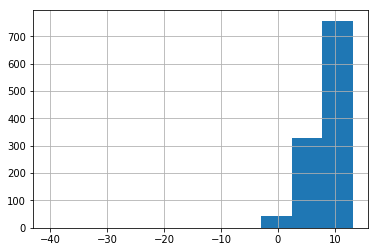

In [398]:
txns[txns['token']=='DAI'].amount.apply(lambda x: np.log(x)).hist()

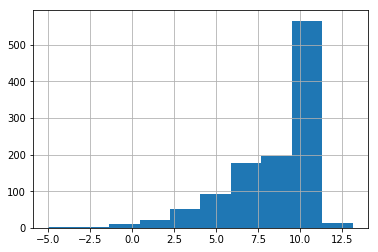

In [399]:
txns[txns['token']=='DAI'].amount.apply(lambda x: np.clip(np.log(x), -5,15)).hist()